<a href="https://colab.research.google.com/github/rostro36/Partisan-Responses/blob/master/network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hnswlib
#https://github.com/nmslib/hnswlib
import hnswlib
phrase_corpus_length=1
node_index=None
phrase_corpus=[]
import networkx as nx
#https://networkx.github.io/documentation/stable/reference/classes/multigraph.html#methods
MG=nx.MultiGraph()
import matplotlib.pyplot as plt
import spacy
sp = spacy.load('en')
import tensorflow as tf
import tensorflow_hub as hub
#https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb#scrollTo=W-q2r7jyZGb7
import numpy as np
import math

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

In [0]:
def lemmatize(phrase):
    return " ".join([word.lemma_ for word in sp(phrase)])

similarity_threshold=0.5

def add_node(phrase):
  global phrase_corpus_length
  phrase_corpus_length=phrase_corpus_length+1
  global phrase_corpus
  phrase_corpus.append(phrase)
  if phrase_corpus_length>2:
    global node_index
    del node_index
  node_index=hnswlib.Index('cosine', 512)
  node_index.init_index(phrase_corpus_length, ef_construction = 200, M = 16, random_seed = 36)
  if phrase_corpus_length>2:
    node_index.load_index("node_index",max_elements=phrase_corpus_length)
  node_index.add_items(model([phrase]))
  node_index.save_index("node_index")
  return

def return_node(phrase):
  print(phrase)
  non_stop_phrase=' '.join([token.text for token in sp(phrase) if not token.is_stop])
  if len(non_stop_phrase)>1:
    phrase=non_stop_phrase
  if node_index is None:
    add_node(phrase)
  nearest_neighbor=node_index.knn_query(model([phrase]))
  if nearest_neighbor!=[]:
    closest_neighbor,closest_distance=nearest_neighbor
    print('hi')
  if closest_neighbor[0]==[]:
    add_node(phrase)
    return phrase
  print(closest_distance[0][0])
  if closest_distance[0][0]>similarity_threshold:
    add_node(phrase)
    return phrase
  return phrase_corpus[closest_neighbor[0][0]]

In [0]:
sample=[[[],[('I','like','ice cream')],[('I', 'introducing','the College Opportunity Tax Credit Act of 2009')],[('This legislation','creates','a new tax credit that will put the cost of higher education in reach for American families'),('a new tax credit','put','the cost of higher education')]],'dem']

def other(partisanship):
  if partisanship =='rep':
    return 'dem'
  if partisanship =='dem':
    return 'rep'
  print(partisanship)
  return None

def add_edge(preprocess_output):
  sentences=preprocess_output[0]
  partisanship=preprocess_output[1]
  for sentence in sentences:
    for phrase in sentence:
      subject=return_node(phrase[0])
      objekt=return_node(phrase[2])
      predicate=lemmatize(phrase[1])
      attributes=MG.get_edge_data(subject,objekt,predicate)
      if attributes:
        MG.remove_edge(subject,objekt,predicate)
        weight=attributes['weight']+1
        if partisanship in ('dem','rep'):
          attributes[partisanship]=attributes[partisanship]+1
        dem=attributes['dem']
        rep=attributes['rep']
      else:
        weight=1
        dem=0
        rep=0
        if partisanship=='dem':
          dem=1
        elif partisanship=='rep':
          rep=1
      MG.add_edge(subject,objekt, key=predicate, weight=weight,dem=dem,rep=rep)

I
hi
1.7881393e-07
ice cream
hi
0.90004796
I
hi
1.7881393e-07
the College Opportunity Tax Credit Act of 2009
hi
1.0398072
This legislation
hi
0.77302694
a new tax credit that will put the cost of higher education in reach for American families
hi
0.48616505
a new tax credit
hi
0.35999382
the cost of higher education
hi
0.8048136
{'weight': 1, 'dem': 1, 'rep': 0}
None
[('I', 'ice cream', 'like'), ('I', 'College Opportunity Tax Credit Act 2009', 'introduce'), ('College Opportunity Tax Credit Act 2009', 'legislation', 'create'), ('College Opportunity Tax Credit Act 2009', 'cost higher education', 'put')]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


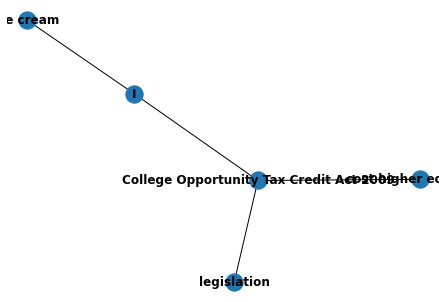

In [4]:
add_edge(sample)

nx.draw(MG, with_labels=True, font_weight='bold')
print(MG.get_edge_data('I','ice cream','like'))
print(MG.get_edge_data('I','ice'))
print(MG.edges)